In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa as ts
import pmdarima as pm
from datetime import datetime

# Linear Regression

In [3]:
data=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\LTC-USD.csv")
vix=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\^VIX.csv")
spy=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\SPY.csv")
ten=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\^TNX.csv")
five=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\^FVX.csv")
thirty=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\^TYX.csv")
ten.columns = ["Date","Open_Ten","High_Ten","Low_Ten","Close_Ten",'Adj_Close_Ten',"Volume_Ten"]
five.columns = ["Date","Open_Five","High_Five","Low_Five","Close_Five",'Adj_Close_Five',"Volume_Five"]
thirty.columns = ["Date","Open_Thirty","High_Thirty","Low_Thirty","Close_Thirty",'Adj_Close_Thirty',"Volume_Thirty"]
spy.columns = ["Date","Open_SPY","High_SPY","Low_SPY","Close_SPY",'Adj_Close_SPY',"Volume_SPY"]
vix.columns = ["Date","Open_VIX","High_VIX","Low_VIX","Close_VIX",'Adj_Close_VIX',"Volume_VIX"]
data = data.merge(vix,on="Date").merge(spy,on="Date").merge(five,on="Date").merge(ten,on="Date").merge(thirty,on="Date")
data["Yield_Spread"] = data["Close_Thirty"]-data["Close_Five"]
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Open_VIX,High_VIX,Low_VIX,...,Close_Ten,Adj_Close_Ten,Volume_Ten,Open_Thirty,High_Thirty,Low_Thirty,Close_Thirty,Adj_Close_Thirty,Volume_Thirty,Yield_Spread
0,2015-11-23,3.14389,3.14672,3.11133,3.12410,3.12410,1389260,16.150000,16.740000,15.38,...,2.250,2.250,0.0,3.045,3.048,2.991,3.007,3.007,0.0,1.326
1,2015-11-24,3.13036,3.13070,3.08787,3.10783,3.10783,1510060,16.530001,17.209999,15.48,...,2.243,2.243,0.0,2.975,3.016,2.969,3.006,3.006,0.0,1.338
2,2015-11-25,3.11383,3.34444,3.09277,3.34444,3.34444,2877300,15.550000,15.890000,15.05,...,2.232,2.232,0.0,2.992,3.001,2.979,2.995,2.995,0.0,1.331
3,2015-11-27,3.60140,3.62843,3.51932,3.57861,3.57861,2780650,15.310000,16.090000,15.12,...,2.225,2.225,0.0,2.975,3.003,2.974,3.001,3.001,0.0,1.348
4,2015-11-30,3.66437,3.73746,3.57929,3.62122,3.62122,3339320,15.550000,16.570000,15.52,...,2.218,2.218,0.0,3.003,3.004,2.983,2.990,2.990,0.0,1.336


In [30]:
datadiff=data.drop("Date",axis=1).diff().loc[1:]
datadiff["Date"]=pd.to_datetime(data["Date"])[1:]+dt.timedelta(days=1)
datadiff.head()
data1lag=data.drop("Date",axis=1)
data1lag["Date"]=pd.to_datetime(data["Date"])+dt.timedelta(days=1)

In [84]:
from sklearn.linear_model import LinearRegression
y=data[data["Date"]>"2017-05-23"]["Close"].diff()[1:]
X=datadiff[datadiff["Date"]>"2017-05-24"].drop("Date",axis=1)[["Close","Volume","Close_VIX","Volume_VIX","Close_SPY","Volume_SPY","Close_Five","Close_Ten","Close_Thirty","Yield_Spread"]][:-1].fillna(0)
lm=LinearRegression()
lm.fit(y=y,X=X)
lm.score(y=y,X=X)

0.04365965886935641

# Time Series

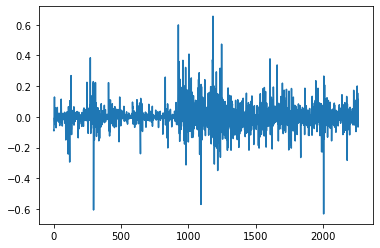

In [34]:
from scipy.stats import boxcox
plt.plot(pd.DataFrame(boxcox(data["Close"])[0]).diff())
dataadj=boxcox(data["Close"])[0]

In [35]:
pm.auto_arima(dataadj, start_p=1, start_q=1,
                         test='adf',
                         start_P=0, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5153.159, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5157.117, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5155.159, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5155.159, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5158.028, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.086 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

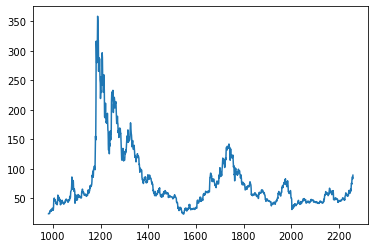

In [46]:
plt.plot(data[data["Date"]>"2017-05-25"]["Close"])

In [49]:
pm.auto_arima(data[data["Date"]>"2017-05-25"]["Close"],start_p=1, start_q=1,
                         test='adf',
                         start_P=0, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8529.844, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8535.191, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8533.240, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8532.765, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8533.262, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8530.256, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8530.561, Time=1.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8530.627, Time=0.56 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8531.889, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8485.446, Time=3.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8531.525, Time=1.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8497.718, Time=4.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8530.861, Time=0.79 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8529.246, Time=1.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

,Date,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,Open,High,Low,Close,Adj Close,Volume
0,2015-11-23,3.143890,3.146720,3.111330,3.124100,3.124100,1389260,16.150000,16.740000,15.380000,15.620000,15.620000,0,209.380005,209.979996,208.520004,209.070007,189.503830,64931200
1,2015-11-24,3.130360,3.130700,3.087870,3.107830,3.107830,1510060,16.530001,17.209999,15.480000,15.930000,15.930000,0,207.869995,209.830002,207.410004,209.350006,189.757660,98874400
2,2015-11-25,3.113830,3.344440,3.092770,3.344440,3.344440,2877300,15.550000,15.890000,15.050000,15.190000,15.190000,0,209.500000,209.740005,209.009995,209.320007,189.730499,51980100
3,2015-11-27,3.601400,3.628430,3.519320,3.578610,3.578610,2780650,15.310000,16.090000,15.120000,15.120000,15.120000,0,209.429993,209.800003,208.860001,209.559998,189.948029,37317800
4,2015-11-30,3.664370,3.737460,3.579290,3.621220,3.621220,3339320,15.550000,16.570000,15.520000,16.129999,16.129999,0,209.750000,209.889999,208.559998,208.690002,189.159454,112822700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2020-11-16,62.279915,71.997322,62.171036,71.326248,71.326248,5089779253,23.660000,24.080000,22.430000,22.450001,22.450001,0,360.980011,362.779999,359.589996,362.570007,362.570007,74541100
1255,2020-11-17,73.501129,76.434593,71.234772,75.852341,75.852341,5781117491,22.840000,24.090000,22.340000,22.709999,22.709999,0,359.970001,361.920013,358.339996,360.619995,360.619995,66111000
1256,2020-11-18,75.849861,76.447357,69.628525,73.694931,73.694931,6120728271,22.860001,23.920000,21.660000,23.840000,23.840000,0,360.910004,361.500000,356.239990,356.279999,356.279999,70591300
1257,2020-11-19,73.695679,83.212341,71.796600,81.683670,81.683670,6615851204,23.620001,24.520000,22.559999,23.110001,23.110001,0,355.600006,358.179993,354.149994,357.779999,357.779999,59940900


In [47]:
arimax=pm.auto_arima(data[data["Date"]>"2017-05-24"]["Close"].diff()[1:],exongenous=datadiff[datadiff["Date"]>="2017-05-25"],start_p=1, start_q=1,
                         test='adf',
                         start_P=0, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                         information_criterion="aicc",
                         stepwise=True)


Performing stepwise search to minimize aicc
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AICC=6084.509, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AICC=6115.048, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AICC=6086.470, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AICC=6082.761, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=6113.090, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AICC=6084.358, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AICC=6086.157, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=6080.782, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=6082.527, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AICC=6082.376, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=6084.491, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AICC=6084.172, Time=0.16 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.314 seconds


In [48]:
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  880
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3038.384
Date:                Tue, 24 Nov 2020   AIC                           6080.768
Time:                        15:58:07   BIC                           6090.328
Sample:                             0   HQIC                          6084.424
                                - 880                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2042      0.009     22.345      0.000       0.186       0.222
sigma2        58.4098      0.737     79.298      0.000      56.966      59.854
===================================================================================
Ljung-Box (Q):                      124.60   Jarque-Bera (JB):             72243.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             2.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
max(data["Date"])

'2020-11-20'

In [54]:
datadiff.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Open_VIX',
       'High_VIX', 'Low_VIX', 'Close_VIX', 'Adj_Close_VIX', 'Volume_VIX',
       'Open_SPY', 'High_SPY', 'Low_SPY', 'Close_SPY', 'Adj_Close_SPY',
       'Volume_SPY', 'Open_Five', 'High_Five', 'Low_Five', 'Close_Five',
       'Adj_Close_Five', 'Volume_Five', 'Open_Ten', 'High_Ten', 'Low_Ten',
       'Close_Ten', 'Adj_Close_Ten', 'Volume_Ten', 'Open_Thirty',
       'High_Thirty', 'Low_Thirty', 'Close_Thirty', 'Adj_Close_Thirty',
       'Volume_Thirty', 'Yield_Spread', 'Date'],
      dtype='object')

# Neural Nets

In [11]:
from tensorflow import keras

## Data Prep

In [7]:
h=1 #forecast horizon
w=20 #window size

In [4]:
def create_timeseries_dataset(X, look_back, look_ahead):
    """
    X is 1D numpy array of timeseries data
    output: row-normalised sliding window array, target array
    """
    dataX, dataY = [], []
    means, sd = [], []
    for i in range(look_back + look_ahead, X.shape[0]):
        # make sliding window of length look_back + look_ahead
        window = X[(i - look_back - look_ahead):i]
        just_duplicate = window
        # calculate mean and std deviation of first look_back elements
        wm = window[:-look_ahead].mean()
        ws = window[:-look_ahead].std()
        means.append(wm)
        sd.append(ws)
        # rescale entire window
        window = (window - wm) / ws
        # split training data from the target
        dataX.append(window[:-look_ahead])
        dataY.append(window[-1])
    # make numpy arrays of the data
    data, target = np.stack(dataX), np.stack(dataY)
    means, sd = np.array(means), np.array(sd)
    # reshape output to: [samples, time steps, features]
    return means, sd, data.reshape((data.shape[0], data.shape[1], 1)), target.reshape((target.shape[0], 1))

In [5]:
def prepare_data(df, look_back=20, look_ahead=1, n_aug=10, scale=0.1, split=(0.6, 0.2, 0.2)):
    """
    df is a pandas series containing prices
    train, validation, and test sets are generated by splitting df and running a sliding window
    training and validation data are augmented by adding noise, random vertical shifts and linear ramps
    """
    # split into train, validation, and test sets
    train_size = int(df.shape[0] * split[0])
    valid_size = int(df.shape[0] * split[1])
    test_size = df.shape[0] - train_size - valid_size

    # reshape into X=t and Y=t+1
    train_mean, train_sd, trainX, trainY = create_timeseries_dataset(df.values[:train_size], look_back, look_ahead)
    valid_mean, valid_sd, validX, validY = create_timeseries_dataset(df.values[train_size:(train_size + valid_size)],
                                                                     look_back, look_ahead)
    test_mean, test_sd, testX, testY = create_timeseries_dataset(df.values[-test_size:], look_back, look_ahead)

    print(train_size, valid_size, test_size)
    print(trainX.shape, trainY.shape)
    print(validX.shape, validY.shape)
    print(testX.shape, testY.shape)

    return (trainX, trainY), (validX, validY), (testX, testY), (train_mean, train_sd), (valid_mean, valid_sd), (
        test_mean, test_sd)

In [8]:
(X_train,Y_train),(X_valid,Y_valid),(X_test,Y_test),(train_mean,train_sd),(valid_mean,valid_sd),(test_mean,test_sd)=prepare_data(data[data["Date"]>="2017-05-25"]["Close"],look_back=w,look_ahead=h)

528 176 177
(507, 20, 1) (507, 1)
(155, 20, 1) (155, 1)
(156, 20, 1) (156, 1)


## Naive Forecast

In [9]:
itr=len(Y_train-h)
errors=[]
for i in range(1,itr):
    errors.append((Y_train[i]-Y_train[i-1])**2)
print("MSE={}".format(sum(errors)/(len(Y_train)-1)))

MSE=[1.06768815]


## Shallow Fully Connected Linear Model

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[w,1]),
    keras.layers.Dense(1)
])
model.compile(optimizer="adam",loss="MeanSquaredError")

In [13]:
model.fit(x=X_train,y=Y_train,epochs=20)

Epoch 1/20
16/16 [==============================] - 0s 1ms/step - loss: 2.7267
Epoch 2/20
16/16 [==============================] - 0s 2ms/step - loss: 2.4901
Epoch 3/20
16/16 [==============================] - 0s 1ms/step - loss: 2.2915
Epoch 4/20
16/16 [==============================] - 0s 1ms/step - loss: 2.1128
Epoch 5/20
16/16 [==============================] - 0s 1ms/step - loss: 1.9607
Epoch 6/20
16/16 [==============================] - 0s 1ms/step - loss: 1.8291
Epoch 7/20
16/16 [==============================] - 0s 1ms/step - loss: 1.7200
Epoch 8/20
16/16 [==============================] - 0s 1ms/step - loss: 1.6196
Epoch 9/20
16/16 [==============================] - 0s 1ms/step - loss: 1.5397
Epoch 10/20
16/16 [==============================] - 0s 2ms/step - loss: 1.4691
Epoch 11/20
16/16 [==============================] - 0s 2ms/step - loss: 1.4050
Epoch 12/20
16/16 [==============================] - 0s 1ms/step - loss: 1.3544
Epoch 13/20
16/16 [==============================

## Simple RNN

In [14]:
model=keras.models.Sequential([
    keras.layers.SimpleRNN(1)
])
model.compile(loss="MeanSquaredError")
model.fit(x=X_train,y=Y_train,epochs=20)

Epoch 1/20
16/16 [==============================] - 0s 6ms/step - loss: 1.8611
Epoch 2/20
16/16 [==============================] - 0s 5ms/step - loss: 1.8382
Epoch 3/20
16/16 [==============================] - 0s 5ms/step - loss: 1.8188
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 1.8001
Epoch 5/20
16/16 [==============================] - 0s 5ms/step - loss: 1.7823
Epoch 6/20
16/16 [==============================] - 0s 6ms/step - loss: 1.7654
Epoch 7/20
16/16 [==============================] - 0s 6ms/step - loss: 1.7495
Epoch 8/20
16/16 [==============================] - 0s 6ms/step - loss: 1.7336
Epoch 9/20
16/16 [==============================] - 0s 6ms/step - loss: 1.7182
Epoch 10/20
16/16 [==============================] - 0s 6ms/step - loss: 1.7044
Epoch 11/20
16/16 [==============================] - 0s 6ms/step - loss: 1.6904
Epoch 12/20
16/16 [==============================] - 0s 6ms/step - loss: 1.6766
Epoch 13/20
16/16 [==============================

## Deep RNN

In [15]:
model=keras.models.Sequential([
    keras.layers.SimpleRNN(w,return_sequences=True),
    keras.layers.SimpleRNN(w,return_sequences=True),
    keras.layers.Dense(1)
])
model.compile(loss="MeanSquaredError")
model.fit(x=X_train,y=Y_train,epochs=20)

Epoch 1/20
16/16 [==============================] - 0s 11ms/step - loss: 2.3864
Epoch 2/20
16/16 [==============================] - 0s 11ms/step - loss: 2.0357
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 1.9943
Epoch 4/20
16/16 [==============================] - 0s 12ms/step - loss: 1.9462
Epoch 5/20
16/16 [==============================] - 0s 11ms/step - loss: 1.9277
Epoch 6/20
16/16 [==============================] - 0s 10ms/step - loss: 1.9028
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 1.8978
Epoch 8/20
16/16 [==============================] - 0s 10ms/step - loss: 1.8752
Epoch 9/20
16/16 [==============================] - 0s 11ms/step - loss: 1.8627
Epoch 10/20
16/16 [==============================] - 0s 10ms/step - loss: 1.8599
Epoch 11/20
16/16 [==============================] - 0s 9ms/step - loss: 1.8546
Epoch 12/20
16/16 [==============================] - 0s 10ms/step - loss: 1.8234
Epoch 13/20
16/16 [====================

## Basic LSTM

In [16]:
model=keras.models.Sequential([
    keras.layers.LSTM(w,return_sequences=True),
    keras.layers.LSTM(w,return_sequences=True),
    keras.layers.LSTM(w,return_sequences=True),
    keras.layers.LSTM(w,return_sequences=True),
    keras.layers.LSTM(w,return_sequences=True),
    keras.layers.Dense(1)
])
model.compile(loss="MeanSquaredError")
model.fit(x=X_train,y=Y_train,epochs=20)

Epoch 1/20
16/16 [==============================] - 1s 52ms/step - loss: 2.8035
Epoch 2/20
16/16 [==============================] - 1s 53ms/step - loss: 2.4732
Epoch 3/20
16/16 [==============================] - 1s 54ms/step - loss: 2.3658
Epoch 4/20
16/16 [==============================] - 1s 55ms/step - loss: 2.3000
Epoch 5/20
16/16 [==============================] - 1s 54ms/step - loss: 2.2793
Epoch 6/20
16/16 [==============================] - 1s 53ms/step - loss: 2.2456
Epoch 7/20
16/16 [==============================] - 1s 55ms/step - loss: 2.2404: 0s - loss: 2.
Epoch 8/20
16/16 [==============================] - 1s 55ms/step - loss: 2.2159
Epoch 9/20
16/16 [==============================] - 1s 55ms/step - loss: 2.1848: 0s - loss: 1.93
Epoch 10/20
16/16 [==============================] - 1s 56ms/step - loss: 2.1836
Epoch 11/20
16/16 [==============================] - 1s 57ms/step - loss: 2.1656
Epoch 12/20
16/16 [==============================] - 1s 55ms/step - loss: 2.1425
Epoch

In [17]:
X_train.shape

(507, 20, 1)

## GRU Cells

In [18]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20,kernel_size=4,strides=2,padding="valid"),
    keras.layers.GRU(20,return_sequences=True),
    keras.layers.GRU(20,return_sequences=True),
    keras.layers.Dense(1)
])
model.compile(optimizer="adam",loss="MeanSquaredError")
model.fit(x=X_train,y=Y_train,epochs=20)

Epoch 1/20
16/16 [==============================] - 0s 13ms/step - loss: 2.9589
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 2.5794
Epoch 3/20
16/16 [==============================] - 0s 11ms/step - loss: 2.2687
Epoch 4/20
16/16 [==============================] - 0s 10ms/step - loss: 2.0820
Epoch 5/20
16/16 [==============================] - 0s 12ms/step - loss: 2.0337
Epoch 6/20
16/16 [==============================] - 0s 13ms/step - loss: 1.9742
Epoch 7/20
16/16 [==============================] - 0s 12ms/step - loss: 1.9409
Epoch 8/20
16/16 [==============================] - 0s 12ms/step - loss: 1.9089
Epoch 9/20
16/16 [==============================] - 0s 13ms/step - loss: 1.8755
Epoch 10/20
16/16 [==============================] - 0s 13ms/step - loss: 1.8499
Epoch 11/20
16/16 [==============================] - 0s 13ms/step - loss: 1.8467
Epoch 12/20
16/16 [==============================] - 0s 12ms/step - loss: 1.8324
Epoch 13/20
16/16 [==================